In [3]:
import pandas as pd
import numpy as np
import json
import re

#Plotting
import matplotlib.pyplot as plt
import FCPython 

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression


import os
import glob

In [4]:
df_scores = pd.read_csv('df_scores.csv')
df_scores_xG = pd.read_csv('df_scores_xG.csv')
df_scores_xG2 = pd.read_csv('df_scores_xG_2.csv')

In [5]:
df_scores

,Unnamed: 0,team_home,team_away,ordresp
0,0,Bayern München,Stuttgart,5.0
1,1,Hoffenheim,Borussia Dortmund,1.0
2,2,Hertha BSC,RB Leipzig,5.0
3,3,Freiburg,Augsburg,1.0
4,4,Schalke 04,Eintracht Frankfurt,2.0
...,...,...,...,...
301,301,Hertha BSC,Stuttgart,1.0
302,302,Hamburger SV,Augsburg,2.0
303,303,Mainz 05,Hannover 96,4.0
304,304,Wolfsburg,Borussia Dortmund,5.0


In [6]:
teams = df_scores.team_home.unique()
teams = sorted(teams)
teams_dict = {}

for index, element in enumerate(teams):
    teams_dict[element] = index +1
    
teams_dict

{'Augsburg': 1,
 'Bayer Leverkusen': 2,
 'Bayern München': 3,
 'Borussia Dortmund': 4,
 "Borussia M'gladbach": 5,
 'Eintracht Frankfurt': 6,
 'Freiburg': 7,
 'Hamburger SV': 8,
 'Hannover 96': 9,
 'Hertha BSC': 10,
 'Hoffenheim': 11,
 'Köln': 12,
 'Mainz 05': 13,
 'RB Leipzig': 14,
 'Schalke 04': 15,
 'Stuttgart': 16,
 'Werder Bremen': 17,
 'Wolfsburg': 18}

In [7]:
df_scores = df_scores.replace(teams_dict)
df_scores = df_scores[['team_home', 'team_away', 'ordresp']]
df_scores

,team_home,team_away,ordresp
0,3,16,5.0
1,11,4,1.0
2,10,14,5.0
3,7,1,1.0
4,15,6,2.0
...,...,...,...
301,10,16,1.0
302,8,1,2.0
303,13,9,4.0
304,18,4,5.0


In [8]:
design_score = pd.DataFrame(columns = np.arange(1,19,1,int))
#design_score.columns = np.arange(1,19,1,int)
design_score
for i, match in df_scores.iterrows():
    design_score.at[i, match['team_home']] = 1
    design_score.at[i, match['team_away']] = -1
    
design_score = design_score.fillna(0)
design_score
    

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
1,0,0,0,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,-1,0,0,0,0
3,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0
302,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
303,0,0,0,0,0,0,0,0,-1,0,0,0,1,0,0,0,0,0
304,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [9]:
ordrespsc = df_scores['ordresp']
ordrespsc

0      5.0
1      1.0
2      5.0
3      1.0
4      2.0
      ... 
301    1.0
302    2.0
303    4.0
304    5.0
305    1.0
Name: ordresp, Length: 306, dtype: float64

In [10]:
def get_estimate(i, p, df):
    get_prob = lambda i, j: np.nan if i == j else p.iloc[i] + p.iloc[j]
    n = df.iloc[i].sum()

    d_n = df.iloc[i] + df.iloc[:, i]
    d_d = pd.Series([get_prob(i, j) for j in range(len(p))], index=p.index)
    d = (d_n / d_d).sum()

    return n / d

def estimate_p(p, df):
    return pd.Series([get_estimate(i, p, df) for i in range(df.shape[0])], index=p.index)


def iterate(df, p=None, n=20, sorted=True):
    if p is None:
        p = pd.Series([1 for _ in range(df.shape[0])], index=list(df.columns))

    estimates = [p]

    for _ in range(n):
        p = estimate_p(p, df)
        p = p / p.sum()
        estimates.append(p)

    p = p.sort_values(ascending=False) if sorted else p
    return p, pd.DataFrame(estimates)

#p, estimates = iterate(df, n=100)

In [11]:
l1_model = LogisticRegression(penalty='l2', solver='liblinear', fit_intercept=True)
l1_model.fit(design_score, ordrespsc)
p_scores = sorted(list(zip(design_score.columns, l1_model.coef_[0])), key=lambda tup: tup[1], reverse=True)
p_scores = pd.Series([c for _, c in p_scores], index=[t for t, _ in p_scores])

teams_dictinv = {v: k for k, v in teams_dict.items()}

p_scores = p_scores.rename(index=teams_dictinv)
p_scores

Bayern München         1.591393
Hoffenheim             0.692898
Schalke 04             0.552254
Borussia Dortmund      0.273936
Bayer Leverkusen       0.135599
RB Leipzig             0.135599
Eintracht Frankfurt    0.135599
Werder Bremen         -0.002559
Hertha BSC            -0.002559
Borussia M'gladbach   -0.002559
Hannover 96           -0.002559
Augsburg              -0.140782
Wolfsburg             -0.140782
Stuttgart             -0.279308
Mainz 05              -0.418386
Köln                  -0.699345
Hamburger SV          -0.841930
Freiburg              -0.986512
dtype: float64

In [12]:
df_scores_xG2 = df_scores_xG2.replace(teams_dict)
df_scores_xG2 = df_scores_xG2[['team_home', 'team_away', 'ordroundxG']]
df_scores_xG2

,team_home,team_away,ordroundxG
0,3,16,3.0
1,11,4,2.0
2,10,14,3.0
3,7,1,2.0
4,15,6,2.0
...,...,...,...
301,10,16,3.0
302,8,1,3.0
303,13,9,3.0
304,18,4,4.0


In [13]:
design_scorexG2 = pd.DataFrame(columns = np.arange(1,19,1,int))
#design_score.columns = np.arange(1,19,1,int)
design_scorexG2
for i, match in df_scores_xG2.iterrows():
    design_scorexG2.at[i, match['team_home']] = 1
    design_scorexG2.at[i, match['team_away']] = -1
    
design_scorexG2 = design_scorexG2.fillna(0)
design_scorexG2

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
1,0,0,0,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,-1,0,0,0,0
3,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0
302,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
303,0,0,0,0,0,0,0,0,-1,0,0,0,1,0,0,0,0,0
304,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [14]:
ordrespxG2 = df_scores_xG2['ordroundxG']
ordrespxG2

0      3.0
1      2.0
2      3.0
3      2.0
4      2.0
      ... 
301    3.0
302    3.0
303    3.0
304    4.0
305    3.0
Name: ordroundxG, Length: 306, dtype: float64

In [15]:
l1_model = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)
l1_model.fit(design_scorexG2, ordrespxG2)
p_scoresxG2 = sorted(list(zip(design_scorexG2.columns, l1_model.coef_[0])), key=lambda tup: tup[1], reverse=True)
p_scoresxG2 = pd.Series([c for _, c in p_scoresxG2], index=[t for t, _ in p_scoresxG2])

teams_dictinv = {v: k for k, v in teams_dict.items()}

p_scoresxG2 = p_scoresxG2.rename(index=teams_dictinv)
p_scoresxG2

Bayern München         2.409240
Bayer Leverkusen       1.281813
Borussia Dortmund      0.791554
Hoffenheim             0.533051
RB Leipzig             0.533040
Augsburg               0.533036
Eintracht Frankfurt    0.267876
Hannover 96            0.000000
Schalke 04             0.000000
Wolfsburg              0.000000
Stuttgart             -0.000096
Freiburg              -0.000102
Borussia M'gladbach   -0.000107
Werder Bremen         -0.000111
Hertha BSC            -0.000114
Mainz 05              -0.266214
Hamburger SV          -0.266228
Köln                  -1.257157
dtype: float64

In [16]:
test = pd.read_csv('2014_2015.csv', delimiter=';', index_col = 0)
df_14_15 = pd.DataFrame()
test


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1,NaN,2:1,0:2,1:0,0:1,1:1,2:1,4:0,3:0,6:0,2:0,4:1,4:0,2:0,1:0,8:0,2:0,4:0
2,4:1,NaN,1:0,4:1,1:0,1:1,2:1,3:0,2:2,2:1,3:0,2:1,2:2,3:1,2:1,2:0,3:0,1:1
3,0:0,1:0,NaN,3:0,1:3,4:1,3:1,3:1,1:3,4:1,1:1,1:0,2:0,1:1,3:2,1:0,1:0,2:0
4,2:0,4:5,1:1,NaN,1:0,1:0,0:0,2:0,1:1,3:3,0:0,5:1,4:0,4:0,4:2,4:0,1:0,2:2
5,0:4,1:0,2:1,2:2,NaN,0:0,2:3,3:1,2:2,4:2,0:2,0:0,1:2,2:1,1:0,3:1,2:0,3:0
6,1:1,3:2,1:0,0:1,1:0,NaN,2:1,3:1,2:2,1:1,4:1,1:2,1:0,3:2,2:0,0:0,0:0,1:0
7,0:1,2:2,1:0,0:2,0:1,3:0,NaN,1:0,2:0,3:2,4:2,0:0,0:1,2:2,2:0,0:1,3:1,3:0
8,0:2,1:1,1:4,0:1,2:0,2:1,1:1,NaN,3:2,1:2,2:0,3:4,4:3,2:1,2:1,3:0,3:3,1:0
9,0:4,1:1,0:0,2:1,0:1,1:0,2:0,3:1,NaN,5:2,2:2,3:2,2:2,4:5,4:4,2:1,1:0,4:0
10,0:4,3:5,0:2,2:1,3:2,0:3,2:1,1:1,1:0,NaN,0:0,0:1,3:3,2:0,2:0,1:0,1:1,4:0


In [17]:
match_14_15 = pd.DataFrame()
for team_home, results in test.iterrows():
    for i in range(0,18):
        if i+1 != team_home:
            row_new = np.zeros(19)
            row_new[team_home-1]=1
            row_new[i]=-1
            erg = results[i]
            # print(erg)
            # print(type(erg))
            goal_diff = int(erg.split(':')[0]) - int(erg.split(':')[1])
            row_new[18] = goal_diff
            # row_new = np.transpose(row_new)
            row_new = pd.DataFrame(row_new)
            row_new = row_new.transpose()
            # print(row_new)
            match_14_15 = pd.concat([match_14_15,row_new], ignore_index=True)

print(match_14_15)

for i, row in match_14_15.iterrows():
    if row[18] <= -2:
        match_14_15.at[i,"ordresp"] = 5
    elif row[18] <0:
        match_14_15.at[i, 'ordresp'] = 4
    elif row[18] ==0:
        match_14_15.at[i, 'ordresp'] = 3
    elif row[18] <2:
        match_14_15.at[i, 'ordresp'] = 2
    elif row[18] >=2:
        match_14_15.at[i, 'ordresp'] = 1
        
        
print(match_14_15)


ordresp_14_15 = match_14_15['ordresp']
match_14_15 = match_14_15.loc[:,match_14_15.columns.isin(range(0,18))]
match_14_15.columns = [pd.Series(range(1,19))]

            
    
            
        


      0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0    1.0 -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    1.0  0.0 -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    1.0  0.0  0.0 -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3    1.0  0.0  0.0  0.0 -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4    1.0  0.0  0.0  0.0  0.0 -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
301  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  0.0   
302  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0   
303  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
304  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
305  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      14   15   16   17   18  
0    0.0  0.0  0.0  0.0  1.0  
1    0.0  0.0

In [18]:
match_14_15

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0
302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0
304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0


In [19]:
ordresp_14_15

0      2.0
1      5.0
2      2.0
3      4.0
4      3.0
      ... 
301    1.0
302    4.0
303    1.0
304    5.0
305    3.0
Name: ordresp, Length: 306, dtype: float64

In [20]:
teams_dict_14_15 = {
    (1,) : 'Bayern München',
    (2,) : 'Wolfsburg',
    (3,) : 'Mönchengladbach',
    (4,) : 'Bayer 04 Leverkusen',
    (5,) : 'Augsburg',
    (6,) : 'Schalke 04',
    (7,) : 'Dortmund',
    (8,) : 'Hoffenheim',
    (9,) : 'Frankfurt',
    (10,) : 'Bremen',
    (11,) : 'Mainz 05',
    (12,) : 'Köln',
    (13,) : 'Hannover',
    (14,) : 'Stuttgart',
    (15,) : 'Hertha BSC',
    (16,) : 'Hamburger SV',
    (17,) : 'SC Freiburg', 
    (18,) : 'Paderborn'    
}

In [21]:
dict_14_15 = {
    1 : 'GAMMA Bayern München',
    2 : 'GAMMA Wolfsburg',
    3 : 'GAMMA Mönchengladbach',
    4 : 'GAMMA Bayer 04 Leverkusen',
    5 : 'GAMMA Augsburg',
    6 : 'GAMMA Schalke 04',
    7 : 'GAMMA Dortmund',
    8 : 'GAMMA Hoffenheim',
    9 : 'GAMMA Frankfurt',
    10 : 'GAMMA Bremen',
    11 : 'GAMMA Mainz 05',
    12 : 'GAMMA Köln',
    13 : 'GAMMA Hannover',
    14 : 'GAMMA Stuttgart',
    15 : 'GAMMA Hertha BSC',
    16 : 'GAMMA Hamburger SV',
    17 : 'GAMMA SC Freiburg', 
    18 : 'GAMMA Paderborn'    
}

In [22]:
l1_model = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)
l1_model.fit(match_14_15, ordresp_14_15)
p_scores_14_15 = sorted(list(zip(match_14_15.columns, l1_model.coef_[0])), key=lambda tup: tup[1], reverse=True)
p_scores_14_15 = pd.Series([c for _, c in p_scores_14_15], index=[t for t, _ in p_scores_14_15])

#teams_dictinv = {v: k for k, v in teams_dict.items()}

p_scores_14_15 = p_scores_14_15.rename(index=teams_dict_14_15)
p_scores_14_15

Bayern München         1.400309
Mönchengladbach        1.226811
Wolfsburg              1.226807
Bayer 04 Leverkusen    0.891734
Dortmund               0.565652
Augsburg               0.404073
Bremen                 0.000000
Mainz 05               0.000000
Köln                   0.000000
Hannover               0.000000
Stuttgart              0.000000
SC Freiburg            0.000000
Frankfurt             -0.081354
Hertha BSC            -0.081365
Schalke 04            -0.081381
Hoffenheim            -0.244940
Hamburger SV          -0.410206
Paderborn             -0.410219
dtype: float64

In [23]:
# set reference team for export 

match_14_15.columns != ('Wolfsburg',)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [24]:
match_14_15 = match_14_15.rename(columns=dict_14_15)
#match_14_15 = match_14_15.loc[:, match_14_15.columns != ('GAMMA Wolfsburg',)]
match_14_15

,GAMMA Bayern München,GAMMA Wolfsburg,GAMMA Mönchengladbach,GAMMA Bayer 04 Leverkusen,GAMMA Augsburg,GAMMA Schalke 04,GAMMA Dortmund,GAMMA Hoffenheim,GAMMA Frankfurt,GAMMA Bremen,GAMMA Mainz 05,GAMMA Köln,GAMMA Hannover,GAMMA Stuttgart,GAMMA Hertha BSC,GAMMA Hamburger SV,GAMMA SC Freiburg,GAMMA Paderborn
0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0
302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0
304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0


In [25]:
cols_14_15 = pd.Series()

for col in match_14_15.columns:
    cols_14_15 = pd.concat([cols_14_15, pd.Series(col[0])])

match_14_15.columns=cols_14_15

match_14_15    
    

,GAMMA Bayern München,GAMMA Wolfsburg,GAMMA Mönchengladbach,GAMMA Bayer 04 Leverkusen,GAMMA Augsburg,GAMMA Schalke 04,GAMMA Dortmund,GAMMA Hoffenheim,GAMMA Frankfurt,GAMMA Bremen,GAMMA Mainz 05,GAMMA Köln,GAMMA Hannover,GAMMA Stuttgart,GAMMA Hertha BSC,GAMMA Hamburger SV,GAMMA SC Freiburg,GAMMA Paderborn
0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0
302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0
304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0


In [26]:
match_14_15_spec = match_14_15
#match_14_15 = match_14_15.loc[:, match_14_15.columns != ('GAMMA Wolfsburg',)]
match_14_15_spec = match_14_15_spec.replace({-1:0})
cols = pd.Series()
for col in match_14_15_spec.columns:
    new_col = col.split('GAMMA')[1]
    new_col = "ALPHA"+new_col
    cols = pd.concat([cols, pd.Series(new_col)])
match_14_15_spec.columns = cols
match_14_15 = match_14_15.loc[:, match_14_15.columns != 'GAMMA Wolfsburg']
match_14_15_spec = pd.concat([match_14_15, match_14_15_spec], axis=1)
match_14_15_spec['ordresp'] = ordresp_14_15

match_14_15_spec

,GAMMA Bayern München,GAMMA Mönchengladbach,GAMMA Bayer 04 Leverkusen,GAMMA Augsburg,GAMMA Schalke 04,GAMMA Dortmund,GAMMA Hoffenheim,GAMMA Frankfurt,GAMMA Bremen,GAMMA Mainz 05,...,ALPHA Bremen,ALPHA Mainz 05,ALPHA Köln,ALPHA Hannover,ALPHA Stuttgart,ALPHA Hertha BSC,ALPHA Hamburger SV,ALPHA SC Freiburg,ALPHA Paderborn,ordresp
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0


In [27]:
match_14_15_spec.to_csv('design_14_15_specific.csv', index=False)


match_14_15_home = match_14_15
match_14_15_home['ordresp'] = ordresp_14_15
match_14_15_home['ALPHA'] = 1

match_14_15_home.to_csv('design_14_15_home.csv', index=False)

In [28]:
result_14_15_specific = pd.read_csv('result_14_15_specific.csv')
result_14_15_specific

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,ALPHA.Frankfurt,1.653536,0.642184,2.574863,1.002799e-02
1,ALPHA.Schalke.04,1.407457,0.636437,2.211464,2.700370e-02
2,ALPHA.Dortmund,0.984731,0.630994,1.560603,1.186174e-01
3,ALPHA.Hoffenheim,0.973365,0.633229,1.537145,1.242578e-01
4,ALPHA.Augsburg,0.962651,0.630697,1.526329,1.269280e-01
5,ALPHA.Hamburger.SV,0.775507,0.635710,1.219907,2.224999e-01
6,GAMMA.Bayern.München,0.763476,0.627904,1.215912,2.240185e-01
7,ALPHA.Mainz.05,0.753656,0.629255,1.197695,2.310359e-01
8,ALPHA.Bayer.04.Leverkusen,0.647887,0.632438,1.024428,3.056330e-01
9,ALPHA.Mönchengladbach,0.597925,0.638115,0.937018,3.487492e-01


In [29]:
result_14_15_home = pd.read_csv('result_14_15_home.csv')
result_14_15_home

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,GAMMA.Bayern.München,0.601923,0.442074,1.361589,1.733278e-01
1,ALPHA,0.527702,0.106729,4.944317,7.641113e-07
2,GAMMA.Wolfsburg,0.000000,NaN,NaN,0.000000e+00
3,GAMMA.Mönchengladbach,-0.163898,0.430364,-0.380835,7.033255e-01
4,GAMMA.Bayer.04.Leverkusen,-0.379755,0.429242,-0.884710,3.763129e-01
5,(Intercept):2,-0.670574,0.067702,-9.904735,3.970208e-23
6,GAMMA.Dortmund,-0.939166,0.429908,-2.184574,2.892010e-02
7,GAMMA.Augsburg,-1.037127,0.430511,-2.409060,1.599369e-02
8,GAMMA.Schalke.04,-1.087004,0.430873,-2.522793,1.164269e-02
9,GAMMA.Mainz.05,-1.198666,0.431810,-2.775910,5.504744e-03


In [30]:
teams_dictinvGAMMA = {k: "GAMMA " + v for k, v in teams_dictinv.items()}
teams_dictinvGAMMA

{1: 'GAMMA Augsburg',
 2: 'GAMMA Bayer Leverkusen',
 3: 'GAMMA Bayern München',
 4: 'GAMMA Borussia Dortmund',
 5: "GAMMA Borussia M'gladbach",
 6: 'GAMMA Eintracht Frankfurt',
 7: 'GAMMA Freiburg',
 8: 'GAMMA Hamburger SV',
 9: 'GAMMA Hannover 96',
 10: 'GAMMA Hertha BSC',
 11: 'GAMMA Hoffenheim',
 12: 'GAMMA Köln',
 13: 'GAMMA Mainz 05',
 14: 'GAMMA RB Leipzig',
 15: 'GAMMA Schalke 04',
 16: 'GAMMA Stuttgart',
 17: 'GAMMA Werder Bremen',
 18: 'GAMMA Wolfsburg'}

In [31]:
teams_dictinvALPHA = {k: "ALPHA " + v for k, v in teams_dictinv.items()}
teams_dictinvALPHA

{1: 'ALPHA Augsburg',
 2: 'ALPHA Bayer Leverkusen',
 3: 'ALPHA Bayern München',
 4: 'ALPHA Borussia Dortmund',
 5: "ALPHA Borussia M'gladbach",
 6: 'ALPHA Eintracht Frankfurt',
 7: 'ALPHA Freiburg',
 8: 'ALPHA Hamburger SV',
 9: 'ALPHA Hannover 96',
 10: 'ALPHA Hertha BSC',
 11: 'ALPHA Hoffenheim',
 12: 'ALPHA Köln',
 13: 'ALPHA Mainz 05',
 14: 'ALPHA RB Leipzig',
 15: 'ALPHA Schalke 04',
 16: 'ALPHA Stuttgart',
 17: 'ALPHA Werder Bremen',
 18: 'ALPHA Wolfsburg'}

In [32]:
#1=0

In [33]:
design_scoreALPHA = design_score.rename(columns=teams_dictinvALPHA)
design_scoreALPHA = design_scoreALPHA.replace({-1:0})
design_scoreALPHA
design_scoreGAMMA = design_score.rename(columns=teams_dictinvGAMMA)
design_scoreGAMMA = design_scoreGAMMA.loc[:,design_scoreGAMMA.columns != "GAMMA Wolfsburg"]
design_scoreGAMMA
design_score_spec = pd.concat([design_scoreGAMMA, design_scoreALPHA, ordrespsc], axis=1)
design_score_spec.to_csv('design_score_spec.csv', index = False)

In [34]:
design_score_home = pd.concat([design_scoreGAMMA, ordrespsc], axis=1)
design_score_home['ALPHA'] = 1
design_score_home.to_csv('design_score_home.csv', index=False)

In [35]:
design_xG2_spec = pd.concat([design_scoreGAMMA, design_scoreALPHA, ordrespxG2], axis=1)
design_xG2_spec.to_csv('design_xG2_spec.csv', index = False)

In [36]:
design_xG2_home = pd.concat([design_scoreGAMMA, ordrespxG2], axis=1)
design_xG2_home['ALPHA'] = 1
design_xG2_home.to_csv('design_xG2_home.csv', index=False)

In [37]:
result_score_home = pd.read_csv('result_score_home.csv')
result_score_home

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,GAMMA.Bayern.München,2.376230,0.463634,5.125222,2.971866e-07
1,GAMMA.Schalke.04,1.029095,0.428739,2.400282,1.638247e-02
2,GAMMA.Hoffenheim,0.886446,0.427268,2.074685,3.801570e-02
3,GAMMA.Borussia.Dortmund,0.760711,0.426230,1.784741,7.430329e-02
4,GAMMA.Bayer.Leverkusen,0.663903,0.425590,1.559960,1.187694e-01
5,GAMMA.RB.Leipzig,0.557600,0.425041,1.311874,1.895628e-01
6,GAMMA.Eintracht.Frankfurt,0.474624,0.424721,1.117498,2.637815e-01
7,ALPHA,0.461027,0.106194,4.341369,1.415975e-05
8,GAMMA.Borussia.M.gladbach,0.365783,0.424443,0.861795,3.888005e-01
9,GAMMA.Hertha.BSC,0.285168,0.424341,0.672026,5.015670e-01


In [38]:
result_score_spec= pd.read_csv('result_score_spec.csv')
result_score_spec

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,GAMMA.Bayern.München,2.167870,0.643689,3.367886,7.574686e-04
1,ALPHA.Hoffenheim,1.524738,0.645988,2.360321,1.825913e-02
2,ALPHA.Freiburg,1.269587,0.643181,1.973918,4.839111e-02
3,ALPHA.Stuttgart,1.143343,0.634614,1.801634,7.160300e-02
4,ALPHA.Borussia.M.gladbach,1.109705,0.634012,1.750289,8.006842e-02
5,ALPHA.Hamburger.SV,1.052095,0.643915,1.633904,1.022790e-01
6,GAMMA.Schalke.04,0.871906,0.620667,1.404789,1.600839e-01
7,GAMMA.Bayer.Leverkusen,0.708816,0.620027,1.143202,2.529547e-01
8,ALPHA.Hannover.96,0.657475,0.631116,1.041766,2.975203e-01
9,GAMMA.Hertha.BSC,0.608976,0.619783,0.982563,3.258225e-01


In [39]:
result_xG2_home = pd.read_csv('result_xG2_home.csv')
result_xG2_home

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,GAMMA.Bayern.München,2.784057,0.462856,6.014948,1.799443e-09
1,GAMMA.Borussia.Dortmund,1.702026,0.442570,3.845778,1.201703e-04
2,GAMMA.Bayer.Leverkusen,1.663128,0.442077,3.762080,1.685060e-04
3,GAMMA.RB.Leipzig,1.276762,0.437882,2.915768,3.548145e-03
4,GAMMA.Eintracht.Frankfurt,1.185435,0.437069,2.712234,6.683130e-03
5,GAMMA.Hoffenheim,0.882839,0.434864,2.030152,4.234108e-02
6,GAMMA.Schalke.04,0.867585,0.434772,1.995493,4.598913e-02
7,ALPHA,0.708301,0.111500,6.352483,2.118675e-10
8,GAMMA.Augsburg,0.637011,0.433641,1.468982,1.418376e-01
9,GAMMA.Hertha.BSC,0.616807,0.433565,1.422640,1.548404e-01


In [40]:
result_xG2_spec= pd.read_csv('result_xG2_spec.csv')
result_xG2_spec

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,GAMMA.Bayern.München,2.867548,0.654066,4.384186,1.164203e-05
1,ALPHA.Freiburg,1.833966,0.652877,2.809053,4.968752e-03
2,GAMMA.Borussia.Dortmund,1.811643,0.641627,2.823516,4.749999e-03
3,GAMMA.Bayer.Leverkusen,1.672870,0.640498,2.611826,9.005997e-03
4,GAMMA.RB.Leipzig,1.449132,0.639013,2.267766,2.334348e-02
5,GAMMA.Hertha.BSC,1.323989,0.638324,2.074165,3.806402e-02
6,GAMMA.Schalke.04,1.204158,0.637803,1.887980,5.902870e-02
7,ALPHA.Augsburg,1.178717,0.643850,1.830733,6.714043e-02
8,ALPHA.Eintracht.Frankfurt,1.155565,0.643634,1.795376,7.259381e-02
9,GAMMA.Hoffenheim,1.142129,0.637579,1.791352,7.323681e-02


In [41]:
result_xG2_spec.sort_values(by=['Estimate'], ascending=False)

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,GAMMA.Bayern.München,2.867548,0.654066,4.384186,1.164203e-05
1,ALPHA.Freiburg,1.833966,0.652877,2.809053,4.968752e-03
2,GAMMA.Borussia.Dortmund,1.811643,0.641627,2.823516,4.749999e-03
3,GAMMA.Bayer.Leverkusen,1.672870,0.640498,2.611826,9.005997e-03
4,GAMMA.RB.Leipzig,1.449132,0.639013,2.267766,2.334348e-02
5,GAMMA.Hertha.BSC,1.323989,0.638324,2.074165,3.806402e-02
6,GAMMA.Schalke.04,1.204158,0.637803,1.887980,5.902870e-02
7,ALPHA.Augsburg,1.178717,0.643850,1.830733,6.714043e-02
8,ALPHA.Eintracht.Frankfurt,1.155565,0.643634,1.795376,7.259381e-02
9,GAMMA.Hoffenheim,1.142129,0.637579,1.791352,7.323681e-02


In [42]:
result_score_home[result_score_home["Unnamed: 0"]=="(Intercept):1"]["Estimate"]

20   -1.719598
Name: Estimate, dtype: float64

In [43]:
database = result_xG2_home

In [44]:
#database = result_score_home
theta_2 = database[database["Unnamed: 0"]=="(Intercept):2"]["Estimate"].item()
theta_1 = database[database["Unnamed: 0"]=="(Intercept):1"]["Estimate"].item()
alpha = database[database["Unnamed: 0"]=="ALPHA"]["Estimate"].item()
erg_1 = np.exp(alpha + theta_1)/(np.exp(alpha + theta_1)+1)
erg_2 = np.exp(alpha + theta_2)/(np.exp(alpha + theta_2)+1) - erg_1
erg_3 = np.exp(alpha - theta_2)/(np.exp(alpha - theta_2)+1) - erg_2 - erg_1
#erg_4 = np.exp(alpha - theta_1)/(np.exp(alpha - theta_1)+1) - erg_1 - erg_2 - erg_3
erg_4 = np.exp(alpha - theta_1)/(np.exp(alpha - theta_1)+1) - np.exp(alpha - theta_2)/(np.exp(alpha - theta_2)+1)
erg_5 = 1- np.exp(alpha - theta_1)/(np.exp(alpha - theta_1)+1)
print(theta_1)
print(theta_2)
print(erg_1)
print(erg_2)
print(erg_3)
print(erg_4)
print(erg_5)
print(erg_1 + erg_2 + erg_3 + erg_4 + erg_5)


-2.7886501200571
-0.902367090745983
0.11102150318643862
0.34061366503443957
0.3818689500823808
0.13709677585578217
0.02939910584095884
1.0


## Nochmal für $k=3$

In [45]:
ordresp_score_3 = pd.Series()
for i,j in design_score_home.iterrows():
    if j["ordresp"] <3:
        temp=1
    elif j["ordresp"] == 3:
        temp=2
    else: 
        temp=3
    
    temp = pd.Series(temp)
    ordresp_score_3 = pd.concat([ordresp_score_3,temp])
ordresp_score_3 = ordresp_score_3.reset_index(drop=True)

In [46]:
design_score_home

,GAMMA Augsburg,GAMMA Bayer Leverkusen,GAMMA Bayern München,GAMMA Borussia Dortmund,GAMMA Borussia M'gladbach,GAMMA Eintracht Frankfurt,GAMMA Freiburg,GAMMA Hamburger SV,GAMMA Hannover 96,GAMMA Hertha BSC,GAMMA Hoffenheim,GAMMA Köln,GAMMA Mainz 05,GAMMA RB Leipzig,GAMMA Schalke 04,GAMMA Stuttgart,GAMMA Werder Bremen,ordresp,ALPHA
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,5.0,1
1,0,0,0,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,1
2,0,0,0,0,0,0,0,0,0,1,0,0,0,-1,0,0,0,5.0,1
3,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,1
4,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,1,0,0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,1.0,1
302,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2.0,1
303,0,0,0,0,0,0,0,0,-1,0,0,0,1,0,0,0,0,4.0,1
304,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,1


In [47]:
design_score_home_3 = design_score_home.drop(design_score_home.columns[17], axis=1).copy()
design_score_home_3["ordresp"] = ordresp_score_3
design_score_home_3

,GAMMA Augsburg,GAMMA Bayer Leverkusen,GAMMA Bayern München,GAMMA Borussia Dortmund,GAMMA Borussia M'gladbach,GAMMA Eintracht Frankfurt,GAMMA Freiburg,GAMMA Hamburger SV,GAMMA Hannover 96,GAMMA Hertha BSC,GAMMA Hoffenheim,GAMMA Köln,GAMMA Mainz 05,GAMMA RB Leipzig,GAMMA Schalke 04,GAMMA Stuttgart,GAMMA Werder Bremen,ALPHA,ordresp
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,3
1,0,0,0,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,1,0,0,0,-1,0,0,0,1,3
3,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,1,1
302,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
303,0,0,0,0,0,0,0,0,-1,0,0,0,1,0,0,0,0,1,3
304,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3


In [48]:
design_score_home_3.to_csv("design_score_home_3.csv", index=False)

In [49]:
design_score_spec_3 = design_score_spec.drop(design_score_spec.columns[35], axis=1).copy()
design_score_spec_3["ordresp"] = ordresp_score_3
design_score_spec_3

,GAMMA Augsburg,GAMMA Bayer Leverkusen,GAMMA Bayern München,GAMMA Borussia Dortmund,GAMMA Borussia M'gladbach,GAMMA Eintracht Frankfurt,GAMMA Freiburg,GAMMA Hamburger SV,GAMMA Hannover 96,GAMMA Hertha BSC,...,ALPHA Hertha BSC,ALPHA Hoffenheim,ALPHA Köln,ALPHA Mainz 05,ALPHA RB Leipzig,ALPHA Schalke 04,ALPHA Stuttgart,ALPHA Werder Bremen,ALPHA Wolfsburg,ordresp
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,-1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,3
3,-1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
302,-1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
303,0,0,0,0,0,0,0,0,-1,0,...,0,0,0,1,0,0,0,0,0,3
304,0,0,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3


In [50]:
design_score_spec_3.to_csv("design_score_spec_3.csv", index=False)

## dasgleiche für die xG im Fall xG2

In [51]:
design_xG2_home

,GAMMA Augsburg,GAMMA Bayer Leverkusen,GAMMA Bayern München,GAMMA Borussia Dortmund,GAMMA Borussia M'gladbach,GAMMA Eintracht Frankfurt,GAMMA Freiburg,GAMMA Hamburger SV,GAMMA Hannover 96,GAMMA Hertha BSC,GAMMA Hoffenheim,GAMMA Köln,GAMMA Mainz 05,GAMMA RB Leipzig,GAMMA Schalke 04,GAMMA Stuttgart,GAMMA Werder Bremen,ordroundxG,ALPHA
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,3.0,1
1,0,0,0,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,2.0,1
2,0,0,0,0,0,0,0,0,0,1,0,0,0,-1,0,0,0,3.0,1
3,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2.0,1
4,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,1,0,0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,3.0,1
302,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3.0,1
303,0,0,0,0,0,0,0,0,-1,0,0,0,1,0,0,0,0,3.0,1
304,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,1


In [52]:
ordresp_xG2_3 = pd.Series()
for i,j in design_xG2_home.iterrows():
    if j["ordroundxG"] <3:
        temp=1
    elif j["ordroundxG"] == 3:
        temp=2
    else: 
        temp=3
    
    temp = pd.Series(temp)
    ordresp_xG2_3 = pd.concat([ordresp_xG2_3,temp])
ordresp_xG2_3 = ordresp_xG2_3.reset_index(drop=True)

In [53]:
ordresp_xG2_3[ordresp_xG2_3 ==3.0]

11     3
12     3
15     3
17     3
18     3
      ..
282    3
287    3
291    3
298    3
304    3
Length: 61, dtype: int64

In [54]:
design_xG2_home

,GAMMA Augsburg,GAMMA Bayer Leverkusen,GAMMA Bayern München,GAMMA Borussia Dortmund,GAMMA Borussia M'gladbach,GAMMA Eintracht Frankfurt,GAMMA Freiburg,GAMMA Hamburger SV,GAMMA Hannover 96,GAMMA Hertha BSC,GAMMA Hoffenheim,GAMMA Köln,GAMMA Mainz 05,GAMMA RB Leipzig,GAMMA Schalke 04,GAMMA Stuttgart,GAMMA Werder Bremen,ordroundxG,ALPHA
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,3.0,1
1,0,0,0,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,2.0,1
2,0,0,0,0,0,0,0,0,0,1,0,0,0,-1,0,0,0,3.0,1
3,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2.0,1
4,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,1,0,0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,3.0,1
302,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3.0,1
303,0,0,0,0,0,0,0,0,-1,0,0,0,1,0,0,0,0,3.0,1
304,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,1


In [55]:
design_xG2_home_3 = design_xG2_home.drop(design_xG2_home.columns[17], axis=1).copy()
design_xG2_home_3["ordroundxG"] = ordresp_xG2_3
design_xG2_home_3

,GAMMA Augsburg,GAMMA Bayer Leverkusen,GAMMA Bayern München,GAMMA Borussia Dortmund,GAMMA Borussia M'gladbach,GAMMA Eintracht Frankfurt,GAMMA Freiburg,GAMMA Hamburger SV,GAMMA Hannover 96,GAMMA Hertha BSC,GAMMA Hoffenheim,GAMMA Köln,GAMMA Mainz 05,GAMMA RB Leipzig,GAMMA Schalke 04,GAMMA Stuttgart,GAMMA Werder Bremen,ALPHA,ordroundxG
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,2
1,0,0,0,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,1,0,0,0,-1,0,0,0,1,2
3,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,1,2
302,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2
303,0,0,0,0,0,0,0,0,-1,0,0,0,1,0,0,0,0,1,2
304,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3


In [56]:
design_xG2_spec.columns[35]

'ordroundxG'

In [57]:
design_xG2_spec_3 = design_xG2_spec.drop(design_xG2_spec.columns[35], axis=1).copy()
design_xG2_spec_3["ordroundxG"] = ordresp_xG2_3
design_xG2_spec_3

,GAMMA Augsburg,GAMMA Bayer Leverkusen,GAMMA Bayern München,GAMMA Borussia Dortmund,GAMMA Borussia M'gladbach,GAMMA Eintracht Frankfurt,GAMMA Freiburg,GAMMA Hamburger SV,GAMMA Hannover 96,GAMMA Hertha BSC,...,ALPHA Hertha BSC,ALPHA Hoffenheim,ALPHA Köln,ALPHA Mainz 05,ALPHA RB Leipzig,ALPHA Schalke 04,ALPHA Stuttgart,ALPHA Werder Bremen,ALPHA Wolfsburg,ordroundxG
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,-1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,2
3,-1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,2
302,-1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
303,0,0,0,0,0,0,0,0,-1,0,...,0,0,0,1,0,0,0,0,0,2
304,0,0,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3


In [58]:
design_xG2_home_3.to_csv("design_xG2_home_3.csv", index=False)
design_xG2_spec_3.to_csv("design_xG2_spec_3.csv", index=False)

## QSE


In [59]:
# kleiner Test

sum(result_14_15_home['Std. Error'].fillna(0))/21

0.3651014188814167

In [60]:
qsescorehome = pd.read_csv('qsescorehome.csv', index_col=0)
qsescoreteamhome = pd.read_csv('qsescoreteamhome.csv', index_col=0)
qsexG2home = pd.read_csv('qsexG2home.csv', index_col=0)
qsexG2teamhome = pd.read_csv('qsexG2teamhome.csv', index_col=0)

In [61]:
np.sqrt(0.349*0.349+0.304*0.304)

0.4628358240240269

In [62]:
2.376-1.029

1.347

In [63]:
print(1.347 + (1.96*0.463))
print(1.347 - (1.96*0.463))

2.25448
0.4395199999999999


In [64]:
qsescoreteamhome

,Team,estimate,SE,quasiSE,quasiVar,Std. Error,z value,Pr(>|z|)
1,ALPHA.Augsburg,-0.344207,0.626628,0.695703,0.484002,0.626628,-0.549300,0.582800
2,ALPHA.Bayer.Leverkusen,-0.125666,0.626052,0.694962,0.482972,0.626052,-0.200727,0.840912
3,ALPHA.Bayern.München,0.457259,0.708343,0.768338,0.590344,0.708343,0.645534,0.518581
4,ALPHA.Borussia.Dortmund,0.417326,0.628772,0.696984,0.485787,0.628772,0.663716,0.506872
5,ALPHA.Borussia.M.gladbach,1.109705,0.634012,0.701077,0.491509,0.634012,1.750289,0.080068
6,ALPHA.Eintracht.Frankfurt,0.398165,0.627689,0.695990,0.484403,0.627689,0.634335,0.525862
7,ALPHA.Freiburg,1.269587,0.643181,0.709200,0.502965,0.643181,1.973918,0.048391
8,ALPHA.Hamburger.SV,1.052095,0.643915,0.710084,0.504220,0.643915,1.633904,0.102279
9,ALPHA.Hannover.96,0.657475,0.631116,0.698820,0.488349,0.631116,1.041766,0.297520
10,ALPHA.Hertha.BSC,-0.662916,0.626587,0.695954,0.484352,0.626587,-1.057979,0.290065


In [65]:
np.sqrt(0.459*0.459+0.696*0.696)

0.833724774730846

In [66]:
qsexG2home.sort_values(by=['estimate'], ascending=False)[["Team","estimate","quasiSE"]].reset_index(drop=True)

,Team,estimate,quasiSE
0,GAMMA.Bayern.München,2.784057,0.334253
1,GAMMA.Borussia.Dortmund,1.702026,0.311223
2,GAMMA.Bayer.Leverkusen,1.663128,0.310733
3,GAMMA.RB.Leipzig,1.276762,0.306944
4,GAMMA.Eintracht.Frankfurt,1.185435,0.306330
5,GAMMA.Hoffenheim,0.882839,0.305075
6,GAMMA.Schalke.04,0.867585,0.305044
7,GAMMA.Augsburg,0.637011,0.304974
8,GAMMA.Hertha.BSC,0.616807,0.305004
9,GAMMA.Hannover.96,0.582286,0.305068


In [67]:
qsexG2teamhome.sort_values(by=['estimate'], ascending=False)

,Team,estimate,SE,quasiSE,quasiVar,Std. Error,z value,Pr(>|z|)
3,GAMMA.Bayern.München,2.867548,0.654066,0.461382,0.212873,0.654066,4.384186,0.000012
4,GAMMA.Borussia.Dortmund,1.811643,0.641627,0.448001,0.200705,0.641627,2.823516,0.004750
2,GAMMA.Bayer.Leverkusen,1.672870,0.640498,0.447069,0.199870,0.640498,2.611826,0.009006
14,GAMMA.RB.Leipzig,1.449132,0.639013,0.446076,0.198984,0.639013,2.267766,0.023343
10,GAMMA.Hertha.BSC,1.323989,0.638324,0.445745,0.198688,0.638324,2.074165,0.038064
15,GAMMA.Schalke.04,1.204158,0.637803,0.445635,0.198590,0.637803,1.887980,0.059029
11,GAMMA.Hoffenheim,1.142129,0.637579,0.445647,0.198601,0.637579,1.791352,0.073237
6,GAMMA.Eintracht.Frankfurt,1.107435,0.637419,0.445606,0.198565,0.637419,1.737375,0.082321
5,GAMMA.Borussia.M.gladbach,0.708499,0.636880,0.447000,0.199809,0.636880,1.112453,0.265943
17,GAMMA.Werder.Bremen,0.706501,0.636873,0.447007,0.199815,0.636873,1.109327,0.267289


## Erstelle Hilfe für Tabellen teamspezifisch 

In [68]:
# Extrahiere Teamnamen aus der Spalte "Unnamed: 0" und entferne Präfixe
result_score_spec['Teamname'] = result_score_spec['Unnamed: 0'].str.replace(r'[A-Z]+\.', '', regex=True)
# Erstelle eine neue Tabelle mit den gewünschten Informationen
results_score_spec_form = pd.DataFrame([])


# Füge die Teamnamen hinzu
results_score_spec_form['Teamname'] = result_score_spec[~result_score_spec['Teamname'].str.startswith('(Intercept)')]["Teamname"].drop_duplicates()
results_score_spec_form["Teamname"] = results_score_spec_form["Teamname"].str.replace("Borussia.gladbach","Borussia.M.gladbach")
results_score_spec_form["Teamname"] = results_score_spec_form["Teamname"].str.replace("Leipzig","RB.Leipzig")
results_score_spec_form = results_score_spec_form.reset_index(drop=True)
results_score_spec_form

,Teamname
0,Bayern.München
1,Hoffenheim
2,Freiburg
3,Stuttgart
4,Borussia.M.gladbach
5,Hamburger.SV
6,Schalke.04
7,Bayer.Leverkusen
8,Hannover.96
9,Hertha.BSC


In [69]:
home_ab = pd.Series()
ausw_ab = pd.Series()
for i in results_score_spec_form["Teamname"]:
    #print(i)
    check = 'ALPHA.' + i
    check_b = "GAMMA." + i
    home_i = result_score_spec[result_score_spec["Unnamed: 0"] == 'ALPHA.' + i]["Estimate"].item() + result_score_spec[result_score_spec["Unnamed: 0"] == 'GAMMA.' + i]["Estimate"].item()
    home_i = pd.Series(home_i)
    ausw_i = result_score_spec[result_score_spec["Unnamed: 0"] == 'GAMMA.' + i]["Estimate"].item()
    ausw_i = pd.Series(ausw_i)
    home_ab = pd.concat([home_ab, home_i])
    ausw_ab = pd.concat([ausw_ab, ausw_i])
results_score_spec_form["Heim"] = pd.DataFrame(home_ab).reset_index(drop=True)
results_score_spec_form["Auswärts"] = pd.DataFrame(ausw_ab).reset_index(drop=True)

# Füge die Platzierungen hinzu
results_score_spec_form['Platz_Heim'] = results_score_spec_form['Heim'].rank(ascending=False, method='min')
results_score_spec_form['Platz_Auswärts'] = results_score_spec_form['Auswärts'].rank(ascending=False, method='min')

# Sortiere die Tabelle nach der Spalte "Heim" absteigend
#results_score_spec_form = results_score_spec_form.sort_values(by='Heim', ascending=False)


print(results_score_spec_form)

               Teamname      Heim  Auswärts  Platz_Heim  Platz_Auswärts
0        Bayern.München  2.625130  2.167870         1.0             1.0
1            Hoffenheim  1.678827  0.154089         2.0             9.0
2              Freiburg  0.313341 -0.956246        11.0            17.0
3             Stuttgart  0.809009 -0.334333         6.0            14.0
4   Borussia.M.gladbach  0.880952 -0.228753         5.0            12.0
5          Hamburger.SV  0.041698 -1.010396        13.0            18.0
6            Schalke.04  1.181338  0.871906         3.0             2.0
7      Bayer.Leverkusen  0.583150  0.708816         9.0             3.0
8           Hannover.96  0.356255 -0.301220        10.0            13.0
9            Hertha.BSC -0.053940  0.608976        17.0             4.0
10             Mainz.05  0.033172 -0.504618        14.0            15.0
11    Borussia.Dortmund  0.930033  0.512707         4.0             5.0
12           RB.Leipzig  0.770437  0.261825         7.0         

## Korrelationskoeffizient berechnen 


In [70]:
ordresp_14_15

0      2.0
1      5.0
2      2.0
3      4.0
4      3.0
      ... 
301    1.0
302    4.0
303    1.0
304    5.0
305    3.0
Name: ordresp, Length: 306, dtype: float64

In [71]:
match_14_15

,GAMMA Bayern München,GAMMA Mönchengladbach,GAMMA Bayer 04 Leverkusen,GAMMA Augsburg,GAMMA Schalke 04,GAMMA Dortmund,GAMMA Hoffenheim,GAMMA Frankfurt,GAMMA Bremen,GAMMA Mainz 05,GAMMA Köln,GAMMA Hannover,GAMMA Stuttgart,GAMMA Hertha BSC,GAMMA Hamburger SV,GAMMA SC Freiburg,GAMMA Paderborn,ordresp,ALPHA
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1
1,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1
2,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1
3,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1
4,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,1
302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,4.0,1
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,1.0,1
304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,5.0,1


In [72]:
for match, result in match_14_15_home.iterrows():
    print(result[result!=0])

GAMMA Bayern München    1.0
ordresp                 2.0
ALPHA                   1.0
Name: 0, dtype: float64
GAMMA Bayern München     1.0
GAMMA Mönchengladbach   -1.0
ordresp                  5.0
ALPHA                    1.0
Name: 1, dtype: float64
GAMMA Bayern München         1.0
GAMMA Bayer 04 Leverkusen   -1.0
ordresp                      2.0
ALPHA                        1.0
Name: 2, dtype: float64
GAMMA Bayern München    1.0
GAMMA Augsburg         -1.0
ordresp                 4.0
ALPHA                   1.0
Name: 3, dtype: float64
GAMMA Bayern München    1.0
GAMMA Schalke 04       -1.0
ordresp                 3.0
ALPHA                   1.0
Name: 4, dtype: float64
GAMMA Bayern München    1.0
GAMMA Dortmund         -1.0
ordresp                 2.0
ALPHA                   1.0
Name: 5, dtype: float64
GAMMA Bayern München    1.0
GAMMA Hoffenheim       -1.0
ordresp                 1.0
ALPHA                   1.0
Name: 6, dtype: float64
GAMMA Bayern München    1.0
GAMMA Frankfurt        -

In [73]:
df_scores

,team_home,team_away,ordresp
0,3,16,5.0
1,11,4,1.0
2,10,14,5.0
3,7,1,1.0
4,15,6,2.0
...,...,...,...
301,10,16,1.0
302,8,1,2.0
303,13,9,4.0
304,18,4,5.0


In [74]:
tabscore = pd.DataFrame({'Team':np.arange(1,19), 'Punkte':np.arange(0,18)})
tabscore["Punkte"] = 0
tabscore

,Team,Punkte
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [75]:
for i, j in df_scores.iterrows():
    if j["ordresp"] <3:
        tabscore.loc[j["team_home"]-1,"Punkte"] +=3
        #print(tabscore[tabscore["Team"] == j["team_home"]]["Punkte"])# +=3
    elif j["ordresp"] == 3:
        #tabscore[tabscore["Team"] == j["team_home"]-1]#["Punkte"] +=1
        #tabscore[tabscore["Team"] == j["team_away"]-1]#["Punkte"] +=1
        tabscore.loc[j["team_home"]-1,"Punkte"] +=1
        tabscore.loc[j["team_away"]-1,"Punkte"] +=1
        #print("Unentschieden")
    else:
        tabscore.loc[j["team_away"]-1,"Punkte"] +=3
        #print("Sieg Auswärts")
        #tabscore[tabscore["Team"] == j["team_away"]-1][#"Punkte"] +=3
    

In [76]:
tabscore["Team"] = tabscore["Team"].replace(teams_dictinv)
#tabscore = tabscore.sort_values(by="Punkte", ascending = False)
tabscore = tabscore.reset_index(drop=True)
tabscore

,Team,Punkte
0,Augsburg,41
1,Bayer Leverkusen,55
2,Bayern München,84
3,Borussia Dortmund,55
4,Borussia M'gladbach,47
5,Eintracht Frankfurt,49
6,Freiburg,36
7,Hamburger SV,31
8,Hannover 96,39
9,Hertha BSC,43


In [77]:
result_score_home

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,GAMMA.Bayern.München,2.376230,0.463634,5.125222,2.971866e-07
1,GAMMA.Schalke.04,1.029095,0.428739,2.400282,1.638247e-02
2,GAMMA.Hoffenheim,0.886446,0.427268,2.074685,3.801570e-02
3,GAMMA.Borussia.Dortmund,0.760711,0.426230,1.784741,7.430329e-02
4,GAMMA.Bayer.Leverkusen,0.663903,0.425590,1.559960,1.187694e-01
5,GAMMA.RB.Leipzig,0.557600,0.425041,1.311874,1.895628e-01
6,GAMMA.Eintracht.Frankfurt,0.474624,0.424721,1.117498,2.637815e-01
7,ALPHA,0.461027,0.106194,4.341369,1.415975e-05
8,GAMMA.Borussia.M.gladbach,0.365783,0.424443,0.861795,3.888005e-01
9,GAMMA.Hertha.BSC,0.285168,0.424341,0.672026,5.015670e-01


In [78]:
strength = pd.DataFrame(['0.177386','0.663903','2.376230','0.760711','0.365783','0.474624','-0.238849','-0.436902','0.053445','0.285168','0.886446','-0.659367','-0.207662','0.557600','1.029095','0.262878','0.187355','0.000000'])

In [79]:
tabscore["Spielstärke"] = strength
tabscore = tabscore.sort_values(by="Punkte", ascending = False)
tabscore = tabscore.reset_index(drop=True)
tabscore

,Team,Punkte,Spielstärke
0,Bayern München,84,2.376230
1,Schalke 04,63,1.029095
2,Borussia Dortmund,55,0.760711
3,Bayer Leverkusen,55,0.663903
4,Hoffenheim,55,0.886446
5,RB Leipzig,53,0.557600
6,Stuttgart,51,0.262878
7,Eintracht Frankfurt,49,0.474624
8,Borussia M'gladbach,47,0.365783
9,Hertha BSC,43,0.285168


In [80]:
type(tabscore["Spielstärke"][0])

str

In [81]:
from scipy.stats import pearsonr

corr,_ = pearsonr(tabscore["Spielstärke"].astype(float),tabscore["Punkte"])
print(corr)

0.9779391969807177


#### überprüfe, ob Formel stimmt; Tut sie aber

In [110]:
import statistics
import math 


zähler = sum((tabscore["Spielstärke"].astype(float) - statistics.mean(tabscore["Spielstärke"].astype(float)))*(tabscore["Punkte"] - statistics.mean(tabscore["Punkte"])))

nenner = math.sqrt(sum((tabscore["Spielstärke"].astype(float) - statistics.mean(tabscore["Spielstärke"].astype(float)))**2) * sum((tabscore["Punkte"] - statistics.mean(tabscore["Punkte"]))**2))

zähler/nenner

0.9779391969807176

In [83]:
np.arange(1,6.1,0.1)

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. ])

In [84]:
tabscore

,Team,Punkte,Spielstärke
0,Bayern München,84,2.376230
1,Schalke 04,63,1.029095
2,Borussia Dortmund,55,0.760711
3,Bayer Leverkusen,55,0.663903
4,Hoffenheim,55,0.886446
5,RB Leipzig,53,0.557600
6,Stuttgart,51,0.262878
7,Eintracht Frankfurt,49,0.474624
8,Borussia M'gladbach,47,0.365783
9,Hertha BSC,43,0.285168


In [85]:
strength

,0
0,0.177386
1,0.663903
2,2.376230
3,0.760711
4,0.365783
5,0.474624
6,-0.238849
7,-0.436902
8,0.053445
9,0.285168


In [86]:
df_scores

,team_home,team_away,ordresp
0,3,16,5.0
1,11,4,1.0
2,10,14,5.0
3,7,1,1.0
4,15,6,2.0
...,...,...,...
301,10,16,1.0
302,8,1,2.0
303,13,9,4.0
304,18,4,5.0


In [87]:
def calculate_cor(df, points_win, strength, teams_dictinv):
    score = pd.DataFrame({'Team':np.arange(1,19), 'Punkte':np.arange(0,18)})
    score["Punkte"] = 0
    for i, j in df.iterrows():
        if j["ordresp"] <3:
            score.loc[j["team_home"]-1,"Punkte"] +=points_win
        elif j["ordresp"] == 3:
            score.loc[j["team_home"]-1,"Punkte"] +=1
            score.loc[j["team_away"]-1,"Punkte"] +=1
        else:
            score.loc[j["team_away"]-1,"Punkte"] +=points_win
    score["Team"] = score["Team"].replace(teams_dictinv)
    score["Spielstärke"] = strength
    score = score.sort_values(by="Punkte", ascending = False)
    score = score.reset_index(drop=True)
    #print(score)
    corr,_ = pearsonr(score["Spielstärke"].astype(float),score["Punkte"])
    return corr
    
        
    


def calculate_cor_cum(df, strength, teams_dictinv):
    points_win = np.arange(1,10.1,0.1)
    corr = pd.Series()
    for i in points_win:
        temp = calculate_cor(df, i, strength, teams_dictinv)
        temp = pd.Series(temp)
        corr = pd.concat([corr, temp])
        
    return corr


cumcorr = calculate_cor_cum(df_scores, strength, teams_dictinv)


        
        
        

In [88]:
cumcorr = cumcorr.reset_index(drop=True)
cumcorr = pd.DataFrame({"Punkte":np.arange(1,10.1,0.1),"Korr":cumcorr})
#cumcorr

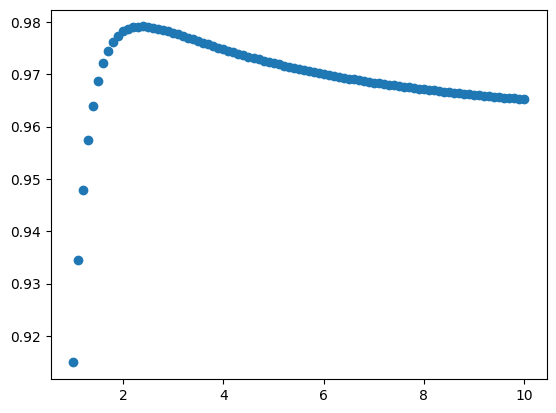

In [89]:
from matplotlib import pyplot 

pyplot.scatter(cumcorr["Punkte"], cumcorr["Korr"])

In [90]:
corr_hin = calculate_cor_cum(df_scores.iloc[0:153], strength, teams_dictinv)
corr_rück = calculate_cor_cum(df_scores.iloc[153:], strength, teams_dictinv)

In [91]:
cumcorr["Hinrunde"] = corr_hin.reset_index(drop=True)
cumcorr["Rückrunde"] = corr_rück.reset_index(drop=True)
cumcorr

,Punkte,Korr,Hinrunde,Rückrunde
0,1.0,0.914900,0.760133,0.727407
1,1.1,0.934439,0.780568,0.759423
2,1.2,0.947940,0.795592,0.785044
3,1.3,0.957380,0.806871,0.805670
4,1.4,0.964043,0.815500,0.822393
...,...,...,...,...
86,9.6,0.965575,0.855884,0.916274
87,9.7,0.965492,0.855884,0.916271
88,9.8,0.965410,0.855884,0.916268
89,9.9,0.965330,0.855883,0.916265


In [92]:
print(cumcorr[cumcorr["Korr"] == max(cumcorr["Korr"])])
print(cumcorr[cumcorr["Hinrunde"] == max(cumcorr["Hinrunde"])])
print(cumcorr[cumcorr["Rückrunde"] == max(cumcorr["Rückrunde"])])

    Punkte      Korr  Hinrunde  Rückrunde
14     2.4  0.979163   0.84662   0.891757
    Punkte      Korr  Hinrunde  Rückrunde
86     9.6  0.965575  0.855884   0.916274
    Punkte      Korr  Hinrunde  Rückrunde
82     9.2  0.965923  0.855882   0.916278


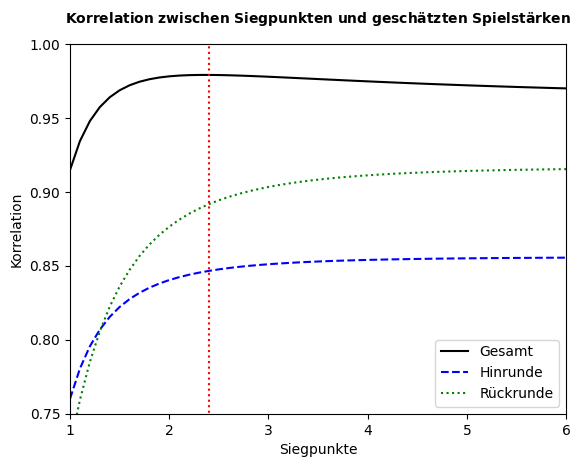

In [93]:
pyplot.plot(cumcorr["Punkte"],cumcorr["Korr"], label="Gesamt", color="black")
pyplot.plot(cumcorr["Punkte"],cumcorr["Hinrunde"], label="Hinrunde", color="blue", linestyle="dashed")
pyplot.plot(cumcorr["Punkte"],cumcorr["Rückrunde"], label="Rückrunde", color="green", linestyle="dotted")
pyplot.vlines(x=2.4,ymin=0,ymax=1, color="red", linestyle="dotted")
pyplot.axis([1,6,0.75,1])
pyplot.xlabel("Siegpunkte")
pyplot.ylabel("Korrelation")
pyplot.title("$\mathbf{Korrelation \ zwischen \ Siegpunkten \ und \ geschätzten\ Spielstärken}$\n", verticalalignment="top", fontsize=10)
pyplot.legend()
